<a href="https://colab.research.google.com/github/DongUk-Park/RnD/blob/main/GNN/Detecting_Anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Data Load & Explore

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
url = 'https://www.hs-coburg.de/fileadmin/hscoburg/WISENT-CIDDS-001.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
import torch

In [ ]:
df = pd.read_csv("CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv")
df.head(5)

<ipython-input-4-e2c685d151d9>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv")


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---


In [ ]:
# 고려하지 않을 feature들은 삭제
# ports, the number of flows, type of service, class, attack ID, and attack description:

df = df.drop(columns=['Src Pt', 'Dst Pt', 'Flows', 'Tos', 'class', 'attackID', 'attackDescription'])
df['attackType'] = df['attackType'].replace('---', 'benign') # ---로 되어있는 공격 타입을 모두 benign(no attack)으로 변경
df['Date first seen'] = pd.to_datetime(df['Date first seen']) # 데이터타입을 datetime으로 변경

benign        82.954273
dos           14.815406
portScan       2.171337
pingScan       0.039744
bruteForce     0.019239
Name: attackType, dtype: float64


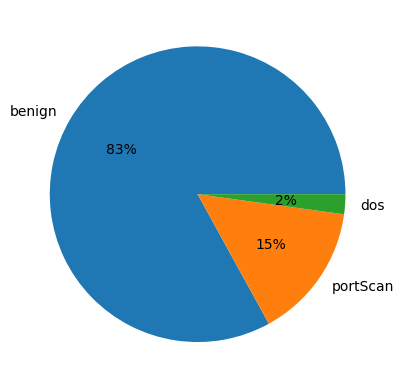

In [ ]:
"""
공격 데이터 분포 살펴보기
"""
count_labels = df['attackType'].value_counts() / len(df) * 100
print(count_labels)
plt.pie(count_labels[:3], labels=df['attackType'].unique()[:3], autopct='%.0f%%')
plt.show()

pingScan와 bruteForce은 샘플이 매우 적은 것을 볼 수 있는데, 이는 모델 학습 시 악영향을 미칠 수 있다

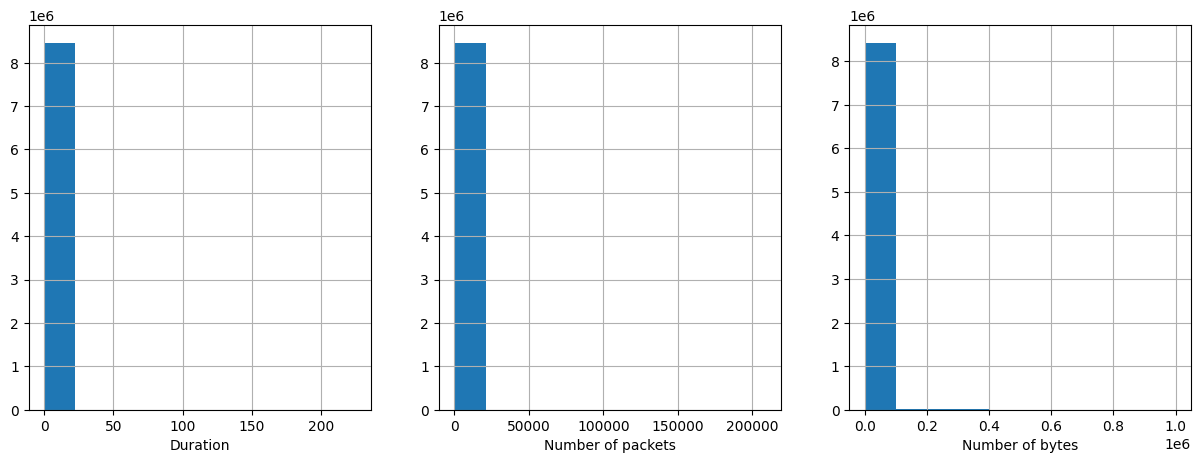

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
pd.to_numeric(df['Bytes'], errors='coerce').hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

대부분의 값은 0에 가깝지만 x축을 따라 뻗어 있는 희귀한 값의 long tail도 있음을 알 수 있습니다. 우리는 이러한 특징을 보다 가우스와 유사하게 만들기 위해 거듭제곱 변환을 사용할 것입니다.

## Data Preprocessing

In [ ]:
"""
타임스탬프에서 요일을 추출하여 원-핫 인코딩할 수 있다
"""
df['weekday'] = df['Date first seen'].dt.weekday # 요일 정보를 숫자로 추출(0~6)
df = pd.get_dummies(df, columns=['weekday']).rename(columns = {'weekday_0': 'Monday',
                                                              'weekday_1': 'Tuesday',
                                                              'weekday_2': 'Wednesday',
                                                              'weekday_3': 'Thursday',
                                                              'weekday_4': 'Friday',
                                                              'weekday_5': 'Saturday',
                                                              'weekday_6': 'Sunday',
                                                             })

#시간을 초단위로 변경 후 정규화 진행(0~1), 새로운 칼럼 추가
df['daytime'] = (df['Date first seen'].dt.second +df['Date first seen'].dt.minute*60 + df['Date first seen'].dt.hour*60*60)/(24*60*60)


In [ ]:
"""
각 플래그는 TCP 연결 중 특정 상태를 나타냅니다.
예를 들어 F 또는 FIN은 TCP 피어가 데이터 전송을 완료했음을 나타냅니다.
각 플래그를 추출하여 다음과 같이 원-핫 인코딩할 수 있습니다.
"""
def one_hot_flags(input):
    return [1 if char1 == char2 else 0 for char1, char2 in zip('APRSF', input[1:])]

df = df.reset_index(drop=True)
ohe_flags = one_hot_flags(df['Flags'].to_numpy())
ohe_flags = df['Flags'].apply(one_hot_flags).to_list()
df[['ACK', 'PSH', 'RST', 'SYN', 'FIN']] = pd.DataFrame(ohe_flags, columns=['ACK', 'PSH', 'RST', 'SYN', 'FIN'])
df = df.drop(columns=['Date first seen', 'Flags'])
df

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,benign,0,1,0,0,0,0,0,0.999954,1,1,0,0,0
8451516,0.000,TCP,10179_174,192.168.210.5,1,54,benign,0,1,0,0,0,0,0,0.999965,1,0,0,0,0
8451517,0.000,TCP,192.168.210.5,10179_174,1,55,benign,0,1,0,0,0,0,0,0.999954,1,0,0,0,0
8451518,0.000,TCP,192.168.100.5,192.168.220.6,1,108,benign,0,1,0,0,0,0,0,0.999977,1,1,0,0,0


In [ ]:
"""
이 예시는 IP 주소를 처리하는데에 이진 인코딩을 사용합니다.
전체 IPv4 주소를 인코딩하는 데 32비트를 사용하는 대신 중요한 마지막 16비트만 유지합니다.
첫 번째 16비트는 호스트가 내부 네트워크에 속하는 경우 192.168에 해당하고
외부 네트워크에 속하는 경우 다른 값에 해당하기 때문입니다.
"""
df = df.iloc[:1000000].reset_index(drop=True) # 데이터가 너무 커서 상위 100만개만 사용

temp = pd.DataFrame()
temp['SrcIP'] = df['Src IP Addr'].astype(str)
# IP 주소 형식에 맞지 않는 엔트리를 '0.0.0.0'으로 설정합니다. (여기서 정규식 \d{1,3}\.는 1~3개의 숫자 다음에 점이 오는 패턴을 찾는데, 이는 올바른 IP 주소 형식을 확인하는 데 사용됩니다.)
temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'

"""
'SrcIP' 칼럼의 IP 주소를 점(.)을 기준으로 분할하고, 각 부분을 별도의 칼럼으로 확장합니다
분할된 IP 주소의 세 번째와 네 번째 옥텟에 해당하는 칼럼의 이름을 각각 'ipsrc3'와 'ipsrc4'로 변경합니다.
이 칼럼들의 값을 정수형으로 변환합니다.
변환된 정수형 칼럼 'ipsrc3'와 'ipsrc4'만 선택합니다.
"""
temp = temp['SrcIP'].str.split('.', expand=True).rename(columns = {2: 'ipsrc3', 3: 'ipsrc4'}).astype(int)[['ipsrc3', 'ipsrc4']]

#temp['ipsrc']:'ipsrc3'와 'ipsrc4' 칼럼의 값을 각각 8자리 이진수로 변환하고, 이 두 이진수를 연결하여 새로운 'ipsrc' 칼럼을 생성합니다.
temp['ipsrc'] = temp['ipsrc3'].apply(lambda x: format(x, "b").zfill(8)) + temp['ipsrc4'].apply(lambda x: format(x, "b").zfill(8))

#.str.split('', expand=True): 'ipsrc' 칼럼을 문자 단위로 분할하고, 각 문자를 별도의 칼럼으로 확장합니다.
#.rename(columns=dict(enumerate([f'ipsrc_{i}' for i in range(17)]))): 나머지 칼럼들을 'ipsrc_0'부터 'ipsrc_15'까지 새로운 이름으로 변경합니다.
df = df.join(temp['ipsrc'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipsrc_{i}' for i in range(17)])))
            .astype('int32'))

In [ ]:
df.head(5)

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,...,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,0,0,1,...,0,0,0,0,0,0,1,1,1,1
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
temp = pd.DataFrame()
temp['DstIP'] = df['Dst IP Addr'].astype(str)
temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['DstIP'].str.split('.', expand=True).rename(columns = {2: 'ipdst3', 3: 'ipdst4'}).astype(int)[['ipdst3', 'ipdst4']]
temp['ipdst'] = temp['ipdst3'].apply(lambda x: format(x, "b").zfill(8)) + temp['ipdst4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipdst'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipdst_{i}' for i in range(17)])))
            .astype('int32'))

print(df.head(5))

   Duration  Proto     Src IP Addr     Dst IP Addr  Packets     Bytes  \
0     0.000  TCP     192.168.100.5  192.168.220.16        1       108   
1     0.000  TCP     192.168.100.5  192.168.220.15        1       108   
2     0.004  TCP    192.168.220.15   192.168.100.5        2       174   
3     0.004  TCP    192.168.220.16   192.168.100.5        2       174   
4     0.000  TCP     192.168.100.5  192.168.220.15        1       108   

  attackType  Monday  Tuesday  Wednesday  ...  ipdst_7  ipdst_8  ipdst_9  \
0     benign       0        0          1  ...        0        0        0   
1     benign       0        0          1  ...        0        0        0   
2     benign       0        0          1  ...        0        0        0   
3     benign       0        0          1  ...        0        0        0   
4     benign       0        0          1  ...        0        0        0   

   ipdst_10  ipdst_11  ipdst_12  ipdst_13  ipdst_14  ipdst_15  ipdst_16  
0         0         0         

'Byte' feature에 문제가 있습니다. 수백만 개가 숫자 값 대신 m으로 표시됩니다. 숫자가 아닌 값의 숫자 부분에 1백만을 곱하여 문제를 해결할 수 있습니다.

In [ ]:
m_index = df[pd.to_numeric(df['Bytes'], errors='coerce').isnull() == True].index
df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
df['Bytes'] = pd.to_numeric(df['Bytes'], errors='coerce', downcast='integer')

<ipython-input-13-c8056af650b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:380: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


In [ ]:
"""
프로토콜 및 공격 유형과 같은 범주형(categorical) feature
pandas의 get_dummies() 함수를 사용
"""
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Proto', 'attackType'])
df.head(5)

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,...,ipdst_14,ipdst_15,ipdst_16,ICMP,IGMP,TCP,UDP,benign,dos,portScan
0,0.000,192.168.100.5,192.168.220.16,1,108,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0.000,192.168.100.5,192.168.220.15,1,108,0,0,1,0,0,...,1,1,1,0,0,1,0,1,0,0
2,0.004,192.168.220.15,192.168.100.5,2,174,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
3,0.004,192.168.220.16,192.168.100.5,2,174,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
4,0.000,192.168.100.5,192.168.220.15,1,108,0,0,1,0,0,...,1,1,1,0,0,1,0,1,0,0


In [ ]:
labels = ['benign', 'dos', 'portScan'] # 정답 레이블 ,'bruteForce','pingScan'
df_train, df_test = train_test_split(df, random_state=0, test_size=0.2, stratify=df[labels]) # 훈련/테스트 데이터 스플릿
df_val, df_test = train_test_split(df_test, random_state=0, test_size=0.5, stratify=df_test[labels])

In [ ]:
"""
지속 시간, 패킷 수, 바이트 수라는 세 가지 feature의 scaling을 해결해야 합니다.
long tail -> Normal distribution

우리는 scikit-learn의 PowerTransformer()를 사용하여 분포를 수정합니다.
"""

scaler = PowerTransformer() # default='yeo-johnson'
df_train[['Duration', 'Packets', 'Bytes']] = scaler.fit_transform(df_train[['Duration', 'Packets', 'Bytes']])
df_val[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_val[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_test[['Duration', 'Packets', 'Bytes']])

In [ ]:
"""
graph의 size가 너무 커서 memory 용량 초과 -> sub graph로 나눈 후 Dataloader에 넣음
"""
BATCH_SIZE = 16
# 앞에서 전처리한 Feature들로 features_host, features_flow 구성
features_host = [f'ipsrc_{i}' for i in range(1, 17)] + [f'ipdst_{i}' for i in range(1, 17)]
features_flow = ['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                 'Duration', 'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN',
                 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']

def get_connections(ip_map, src_ip, dst_ip): # src, dst ip 끼리 엣지를 생성해주는 함수
    # ipmap에서 출발과 도착 ip의 인덱스 번호를 가져옴
    src1 = [ip_map[ip] for ip in src_ip]
    src2 = [ip_map[ip] for ip in dst_ip]
    src = np.column_stack((src1, src2)).flatten() # 출발과 도착 인덱스를 열 방향으로 묶어줌
    dst = list(range(len(src_ip))) # src를 인덱싱해주기 위해  0~src길이 만큼의 list 생성
    dst = np.column_stack((dst, dst)).flatten() # 인덱스 번호리스트끼리 열 방향으로 묶어줌
    # 순방향 텐서, 역방향 텐서를 각각 만들어서 return함
    return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()

def create_dataloader(df, subgraph_size=1024):
    data = [] # 배치 크기로 나눈 subgraph들을 저장할 리스트
    n_subgraphs = len(df) // subgraph_size # sub graph의 개수
    for i in range(1, n_subgraphs+1):
        subgraph = df[(i-1)*subgraph_size:i*subgraph_size] # df에서 subgraph_size만큼씩 데이터를 가져옴
        src_ip = subgraph['Src IP Addr'].to_numpy() # subgraph에서 src_ip만 가져옴
        dst_ip = subgraph['Dst IP Addr'].to_numpy() # subgraph에서 dst_ip만 가져옴

        # src_ip, dst_ip의 모든 ip들을 모아 중복제거 후, ip와 index 번호를 key:value로 지정한 dictionary 생성
        # 이 index는 엣지를 연결할 때 사용
        ip_map = {ip:index for index, ip in enumerate(np.unique(np.append(src_ip, dst_ip)))}
        host_to_flow, flow_to_host = get_connections(ip_map, src_ip, dst_ip)

        batch = HeteroData() # 객체 생성
        # host, flow에 노드의 feature 할당, 텐서로 변환
        batch['host'].x = torch.Tensor(subgraph[features_host].to_numpy()).float()
        batch['flow'].x = torch.Tensor(subgraph[features_flow].to_numpy()).float()

        # flow 노드의 레이블을 할당. 분류작업을 수행할 때 flow의 타겟 레이블로 사용됨
        batch['flow'].y = torch.Tensor(subgraph[labels].to_numpy()).float()

        # 간선 정보 할당
        batch['host','flow'].edge_index = host_to_flow
        batch['flow','host'].edge_index = flow_to_host
        data.append(batch)

    return DataLoader(data, batch_size=BATCH_SIZE)

train_loader = create_dataloader(df_train)
val_loader = create_dataloader(df_val)
test_loader = create_dataloader(df_test)

<ipython-input-17-80bcb0467cb7>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()


In [ ]:
from torch_geometric.nn import Linear, HeteroConv, SAGEConv, GATConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, dim_h, dim_out, num_layers): # 은닉층, 출력층(최종 예측) 차원, 그래프 conv 레이어 개수
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers): # num_layer : 3
            # 여러 유형의 간선에 대해 다른 conv 연산을 수행할 수 있는 이종 그래프 컨볼루션 레이어
            conv = HeteroConv({
                ('host', 'to', 'flow'): SAGEConv((-1,-1), dim_h, add_self_loops=False), # -1,-1는 자동으로 입력 차원을 결정
                ('flow', 'to', 'host'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(dim_h, dim_out) # 최종 은닉층의 출력을 예측 레이블의 차원으로 변환

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            # 노드 유형(host, flow)별로 분류된 노드의 feature 담고 있는 dictionary
            # computes embeddings for host and flow nodes
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()} # 각 레이어의 출력에 leaky_relu를 적용한다
        return self.lin(x_dict['flow'])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(dim_h=64, dim_out=3, num_layers=3).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = [] # 예측 결과를 담을 리스트
    y_true = [] # 정답을 담을 리스트
    n_subgraphs = 0
    total_loss = 0

    for batch in loader:
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        y_pred.append(out.argmax(dim=1))
        y_true.append(batch['flow'].y.argmax(dim=1))
        n_subgraphs += BATCH_SIZE # 16
        total_loss += float(loss) * BATCH_SIZE

    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true).cpu()
    f1score = f1_score(y_true, y_pred, average='macro')

    return total_loss/n_subgraphs, f1score, y_pred, y_true


model.train()
for epoch in range(31):
    n_subgraphs = 0
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch.to(device)

        out = model(batch.x_dict, batch.edge_index_dict)

        loss = F.cross_entropy(out, batch['flow'].y.float())
        loss.backward()
        optimizer.step()

        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE

    if epoch % 10 == 0:
        val_loss, f1score, _, _ = test(val_loader)
        print(f'Epoch {epoch} | Loss: {total_loss/n_subgraphs:.4f} | Val loss: {val_loss:.4f} | Val F1-score: {f1score:.4f}')


Epoch 0 | Loss: 0.5326 | Val loss: 0.1827 | Val F1-score: 0.3314
Epoch 10 | Loss: 0.0028 | Val loss: 0.0024 | Val F1-score: 0.9899
Epoch 20 | Loss: 0.0012 | Val loss: 0.0009 | Val F1-score: 0.9951
Epoch 30 | Loss: 0.0009 | Val loss: 0.0007 | Val F1-score: 0.9960


In [ ]:
_, _, y_pred, y_true = test(test_loader)

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      benign     1.0000    0.9999    0.9999     87531
         dos     1.0000    1.0000    1.0000     10846
    portScan     0.9865    0.9958    0.9911       951

    accuracy                         0.9998     99328
   macro avg     0.9955    0.9985    0.9970     99328
weighted avg     0.9998    0.9998    0.9998     99328



([<matplotlib.patches.Wedge at 0x780c88f006a0>,
 [Text(-0.8129098415937982, 0.7410651721946903, ''),
  Text(0.8129098762855613, -0.7410651341396339, '')],
 [Text(-0.4434053681420717, 0.4042173666516492, '76%'),
  Text(0.4434053870648516, -0.4042173458943457, '24%')])

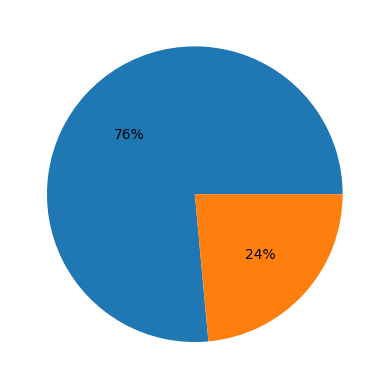

In [ ]:
df_pred = pd.DataFrame([y_pred.numpy(), y_true.numpy()]).T
df_pred.columns = ['pred', 'true']
plt.pie(df_pred['true'][df_pred['pred'] != df_pred['true']].value_counts(), labels=labels.extend(['pingScan','bruteForce']), autopct='%.0f%%')

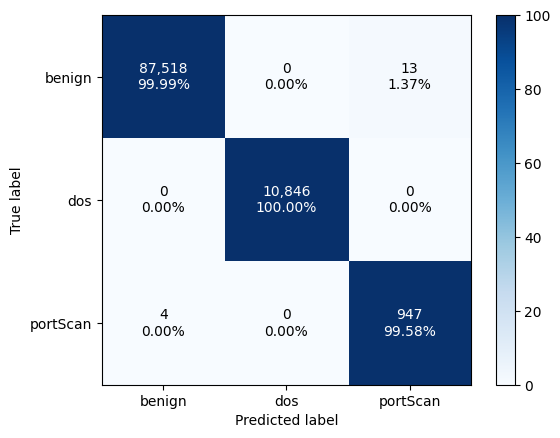

In [ ]:
matrix = confusion_matrix(y_true, y_pred)
norm_matrix = matrix / matrix.sum(axis=1) * 100

plt.imshow(norm_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)

for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    text = f"{matrix[i,j]:,}\n{norm_matrix[i,j]:.2f}%"
    plt.text(j, i, text,
            horizontalalignment='center', verticalalignment='center',
            color='white' if matrix[i,j] >= matrix[i,:].mean() else 'black')
plt.show()